# Income Prediction Classifier

# Imports

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import BinaryEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_curve, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, RepeatedStratifiedKFold, train_test_split

# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"The Amount of Null values: {df.isna().sum()}")
  print(f"The Amount of Dupe values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Class Breakdown")
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(df, y, axis):
  
  fig, ax = plt.subplots(figsize=(12, 7))
  df.plot.bar(x='Model', y=y, ax=ax)
  ax.set_xlabel("Model")
  ax.set_ylabel(axis)
  ax.set_title("Model Performance")
  plt.legend(y)
  plt.xticks(rotation=45)
  ax.grid(True)
  plt.show()
  
def create_plot_graph(metrics, axis, sort_col):
  df = pd.DataFrame(metrics).sort_values(by=sort_col, ascending=False)
  y = [ col for col in df.columns if col !="Model"]
  plot_model_performance(df, y, axis)
  print(df)

def create_sklearn_pipeline(model, model_name):
  
  steps = [
    (model_name, model)
  ]
  return sklearnPipeline(steps=steps)

def pca_analysis(X):
  
  metric_tracker, explained_variances= [], []
  features = range(1, X.shape[1]+1)
  model_name ="PCA"
  for n_component in features:
    pca= PCA(n_components=n_component)
    pipeline = create_sklearn_pipeline(pca, model_name)
    X_pca = pipeline.fit_transform(X)
    
    explained_variance_per_n = np.sum(pca.explained_variance_ratio_)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))
    
    metric_tracker.append({
      "Model": model_name,
      "Explained Variance Per N": explained_variance_per_n,
      "N":n_component
    })

  cumulative_variances = np.cumsum(explained_variances)
  plt.figure(figsize=(8, 5))
  plt.plot(features, cumulative_variances, marker='o', linestyle="-")
  plt.title("Cumulative Explained Variance By PCA Components")
  plt.xlabel("Components")
  plt.ylabel("Cumulative Explained Variance")
  plt.grid(True)
  plt.show()
  
  create_plot_graph(metric_tracker, "N", "Explained Variance Per N")

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier(),
    "Dummy": DummyClassifier(strategy="constant", constant=1)
  }
  
  return [models[model] for model in model_names]


def evaluate_model(model, X, y, scoring_metric):
  
  cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42)
  scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_metric, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
  
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions, average="weighted")
  recall_metric = recall_score(y, predictions)
  precision_metric = precision_score(y, predictions)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(recall_metric,3),
    round(precision_metric,3),
  ]

def test_selected_models(model_names, models, X, y, scoring_metric):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline( model, model_name)
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "F1-Score":scores[4],
      "recall-Score":scores[5],
      "precision-Score":scores[6]
    })
  
  create_plot_graph(metric_tracker, "metrics", "Mean")


# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/adult.csv")
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


# Check for nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The Amount of Null values: age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64
The Amount of Dupe values: 24


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

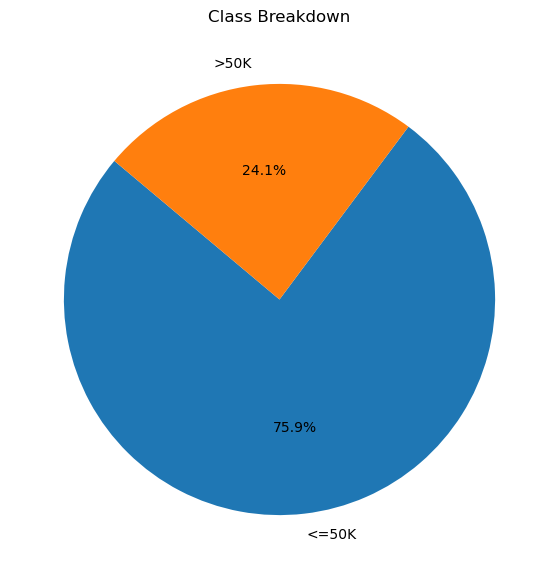

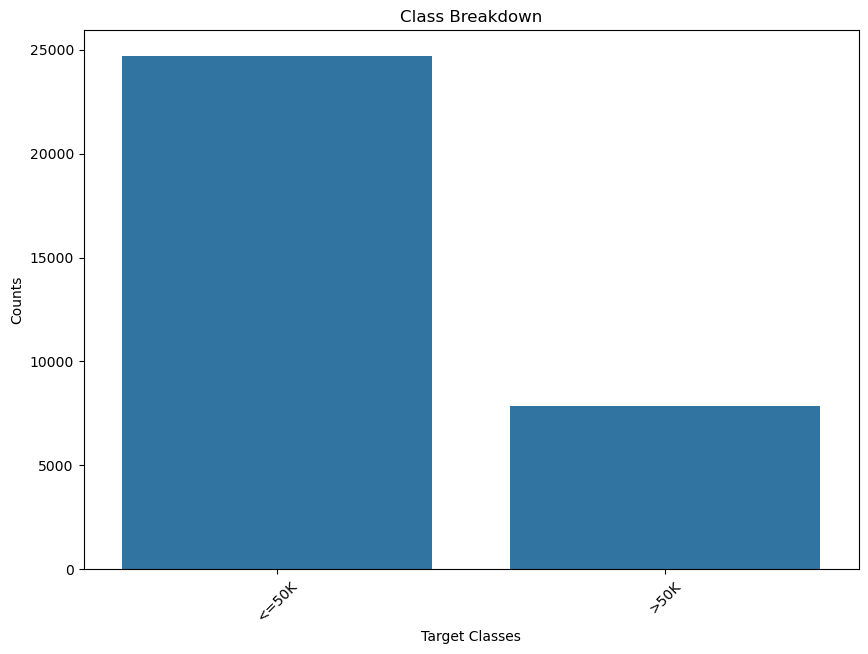

In [6]:
check_class_imbalance(df['income'])

# Class Imbalance exists

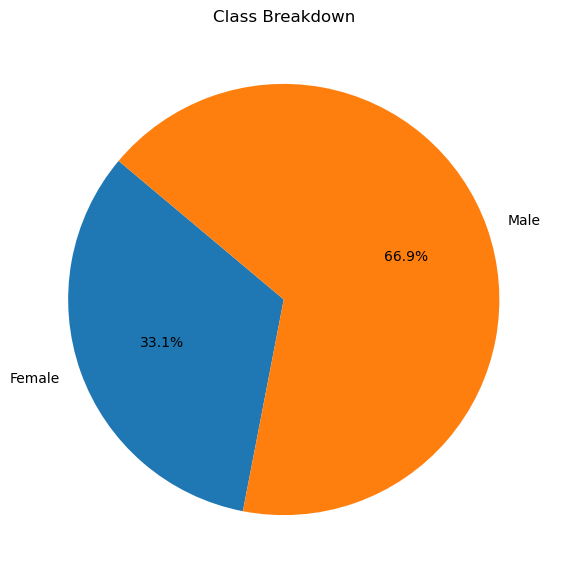

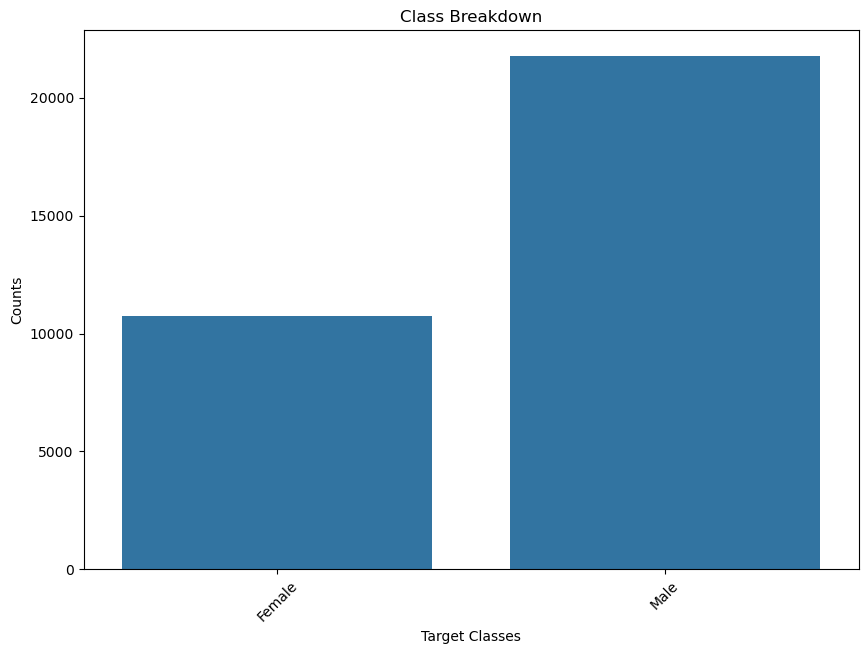

In [7]:
check_class_imbalance(df["sex"])

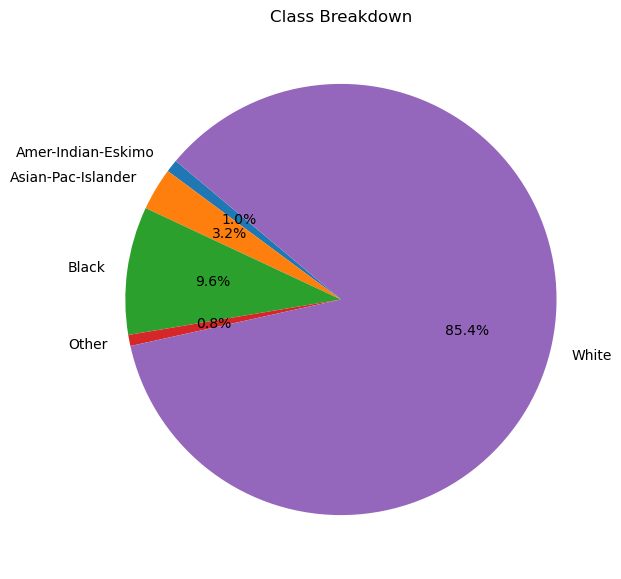

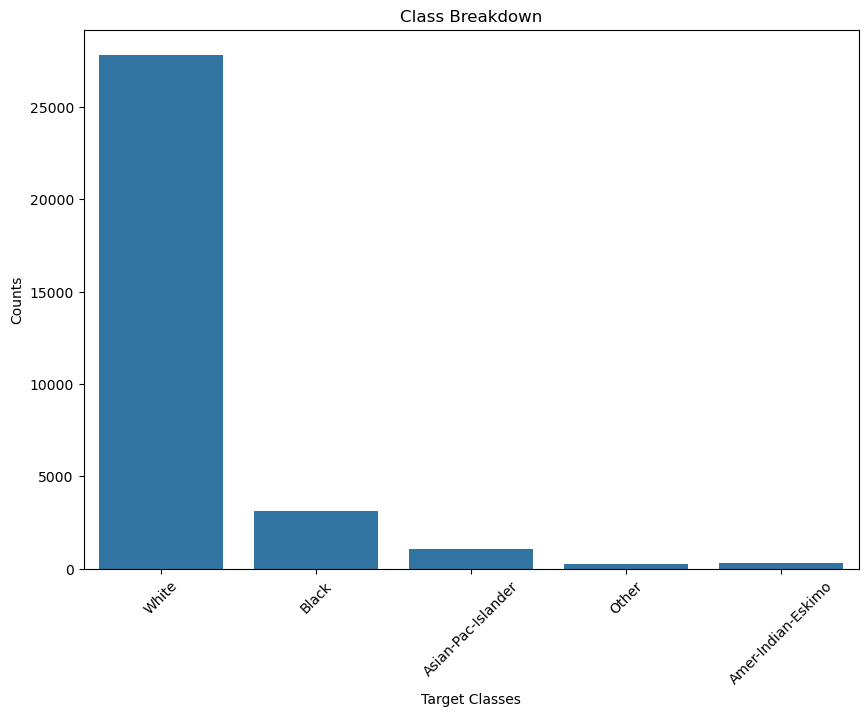

In [8]:
check_class_imbalance(df["race"])

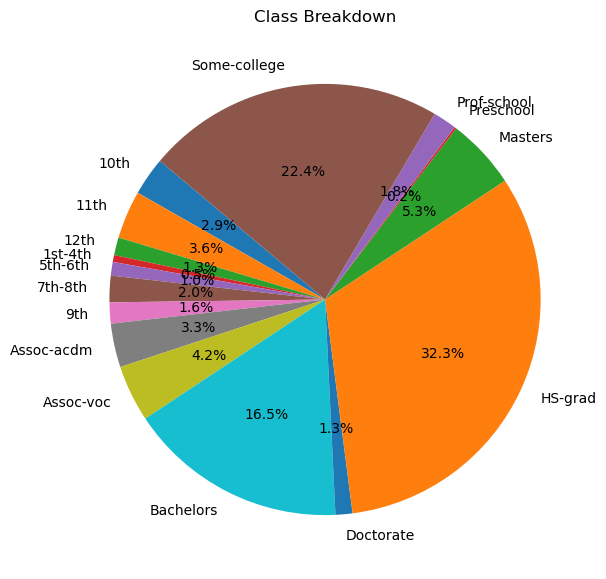

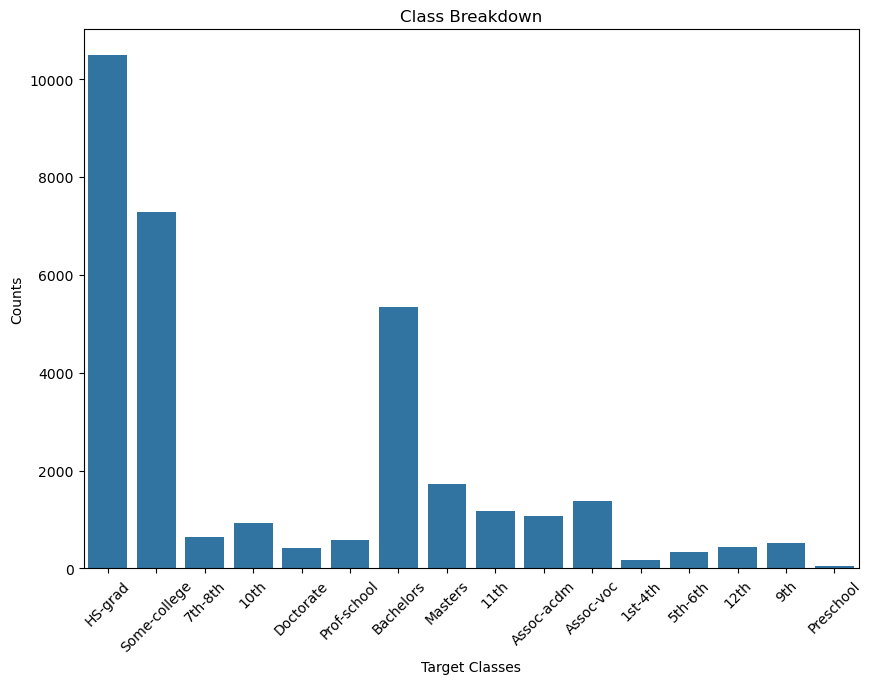

In [9]:
check_class_imbalance(df['education'])

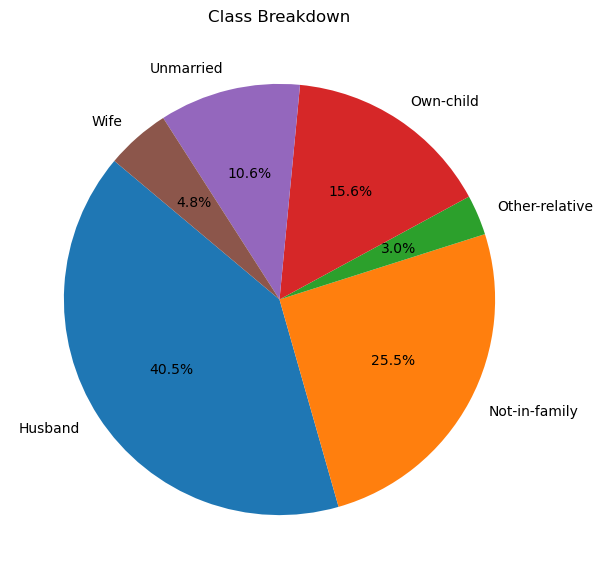

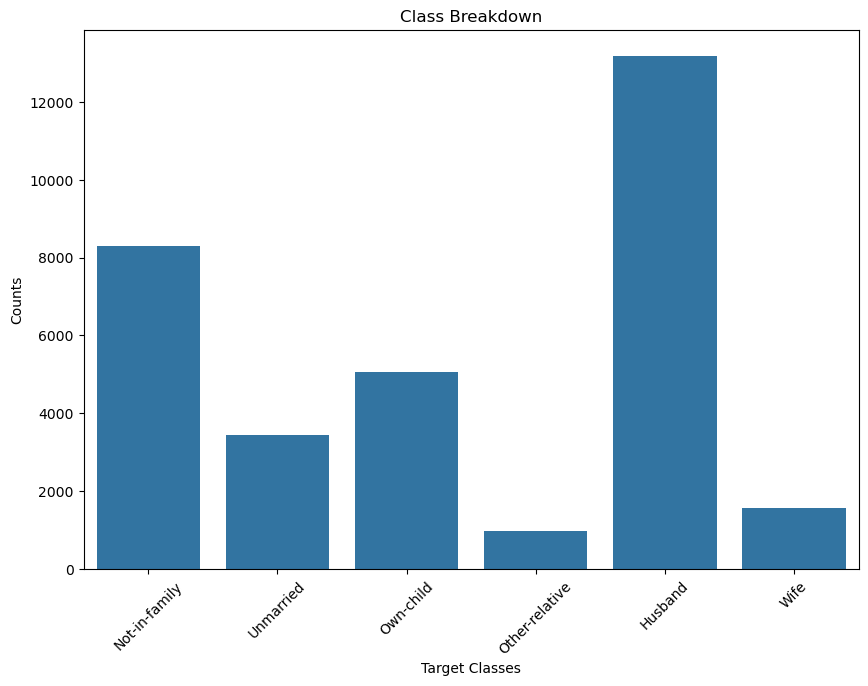

In [10]:
check_class_imbalance(df["relationship"])

# Class imbalance exists throughout our dataset

In [11]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [13]:
df["workclass"].value_counts()

Private             22673
Self-emp-not-inc     2540
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [14]:
df["marital.status"].value_counts()

Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

In [15]:
df["occupation"].value_counts()

Prof-specialty       4136
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
?                    1843
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: occupation, dtype: int64

In [16]:
df["race"].value_counts()

White                 27795
Black                  3122
Asian-Pac-Islander     1038
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

In [17]:
df["native.country"].value_counts()

United-States                 29153
Mexico                          639
?                               582
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        62
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

# We have an issue here, if we take our categorical features and one hot encode them, the dimensions of our dataset will explode, creating a sparse matrix that will perform poorly. We can continue this route and then turn this into a dense matrix using various transformations or we can use Binary Encoder which bins our string data into numerical representations. 

In [31]:
numeric_features = df.select_dtypes(include="int64")
categorical_features =  df.select_dtypes(include="object").drop(["income", "education"], axis=1)

# Visuals

<AxesSubplot:>

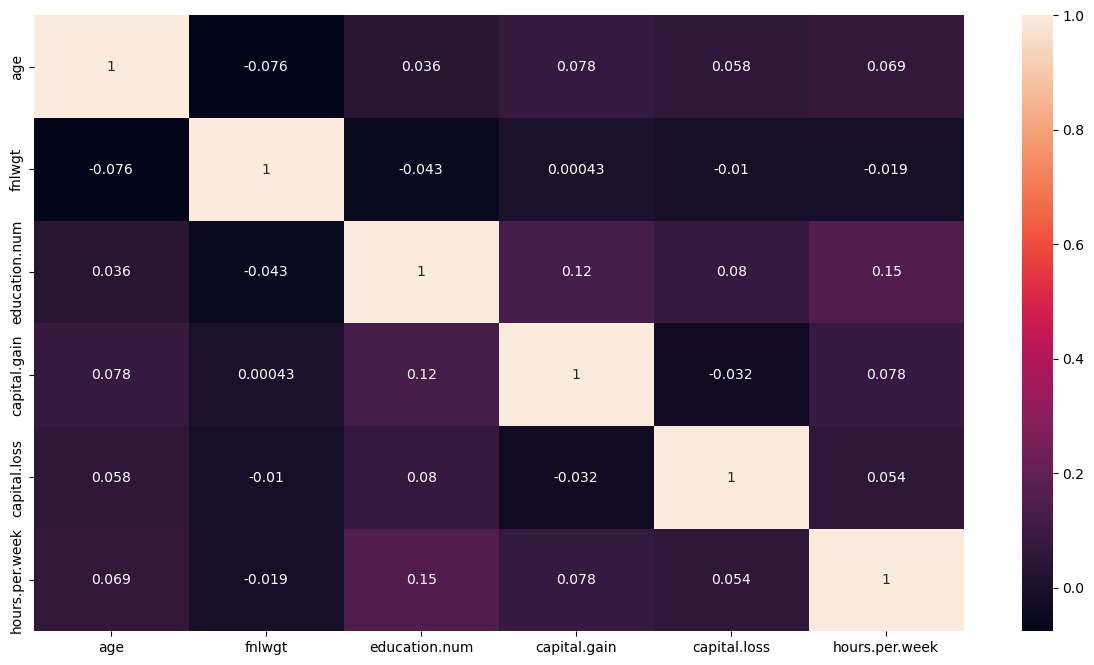

In [19]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=df.corr(), annot=True)

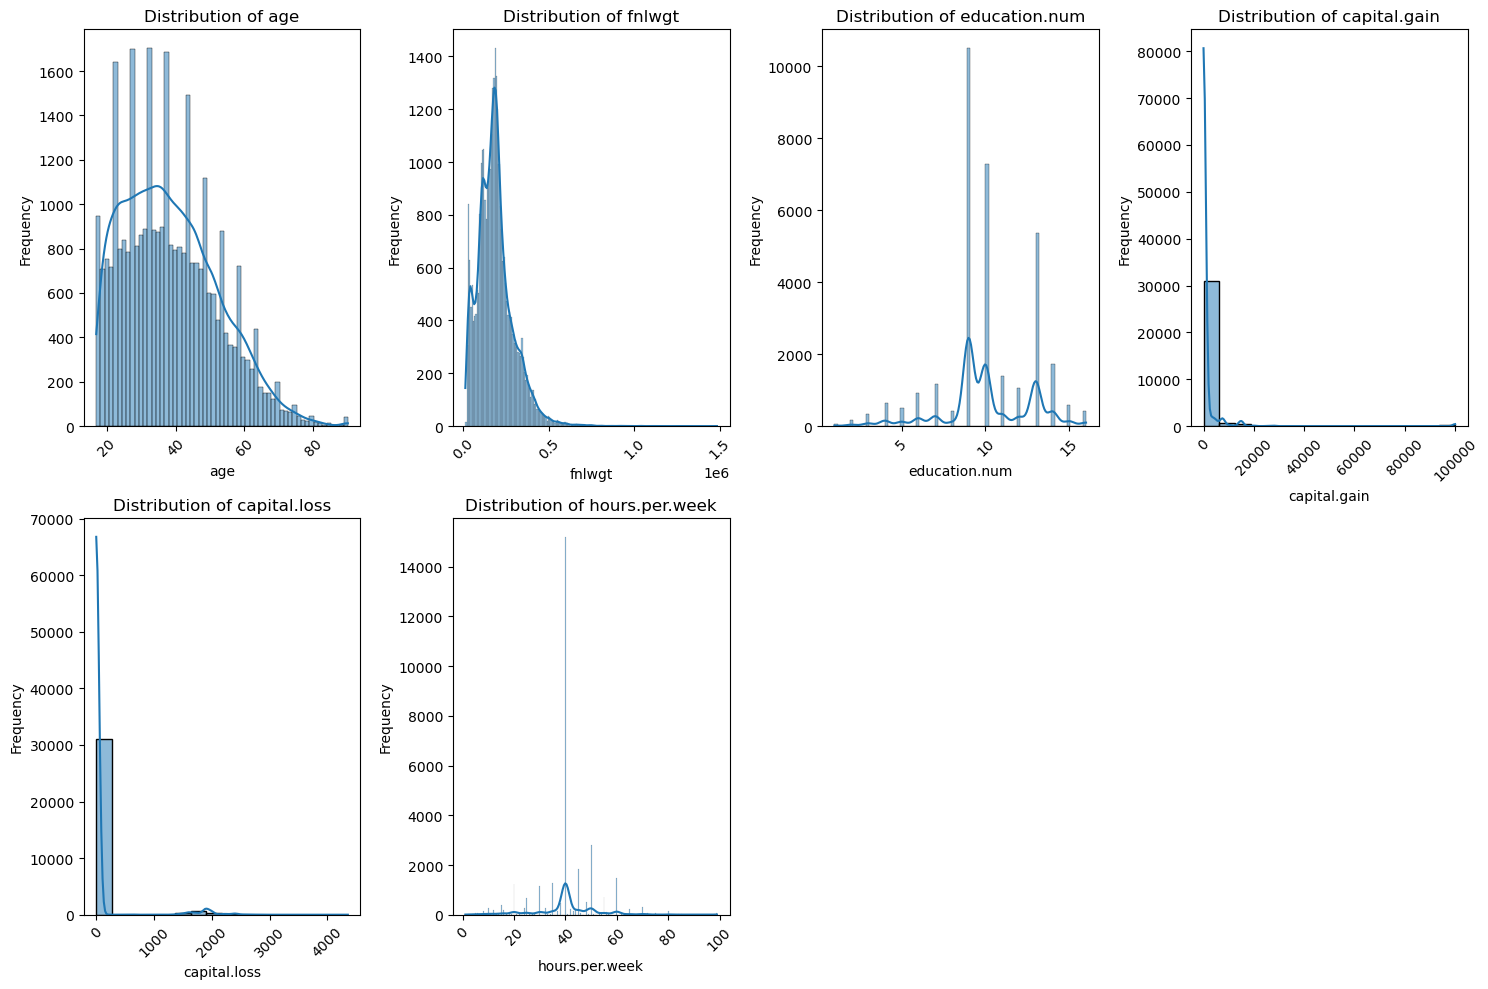

In [20]:
plt.figure(figsize=(15, 10))
rows = len(numeric_features.columns)
dims = (rows+3)//4

for idx, col in enumerate(numeric_features.columns):
  plt.subplot(dims, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

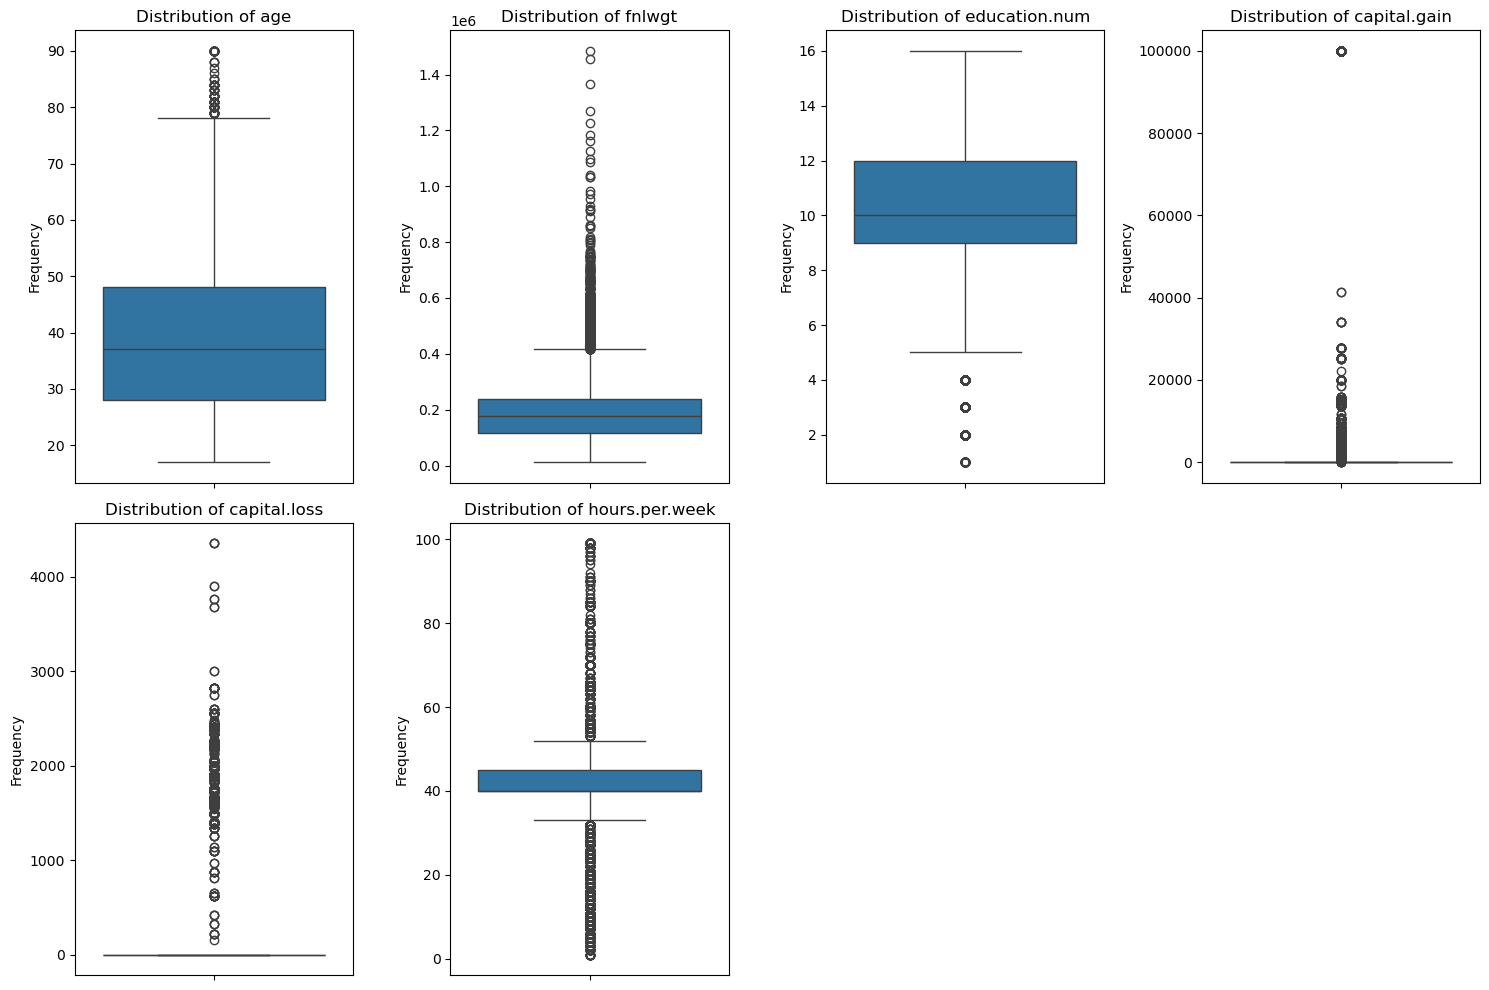

In [21]:
plt.figure(figsize=(15, 10))
rows = len(numeric_features.columns)
dims = (rows+3)//4

for idx, col in enumerate(numeric_features.columns):
  plt.subplot(dims, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Lots of outliers in our dataset, we will have to use Min Max Scaling in order to deal with these outliers

# Separate Feature Variables

In [49]:
X, y = df.drop(["income", "education"], axis=1), df["income"]

# Create Training and Testing Data

In [44]:
X_train, X_temp, y_train, y_temp= train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [50]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)


In [51]:
for col in categorical_features.columns:
  X[col] = encoder.fit_transform(X[col])

# PCA-Analysis

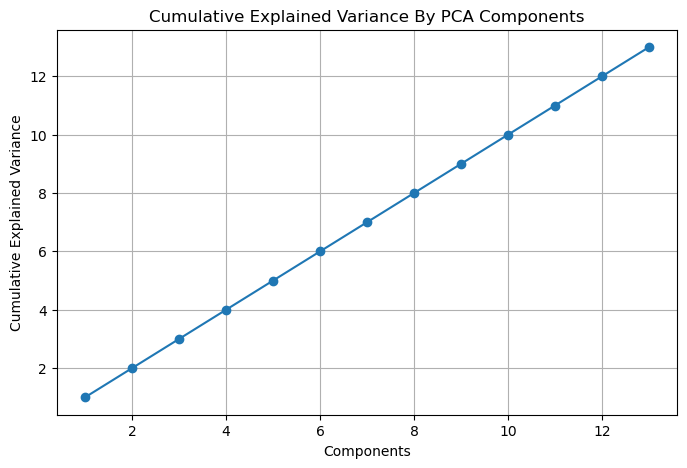

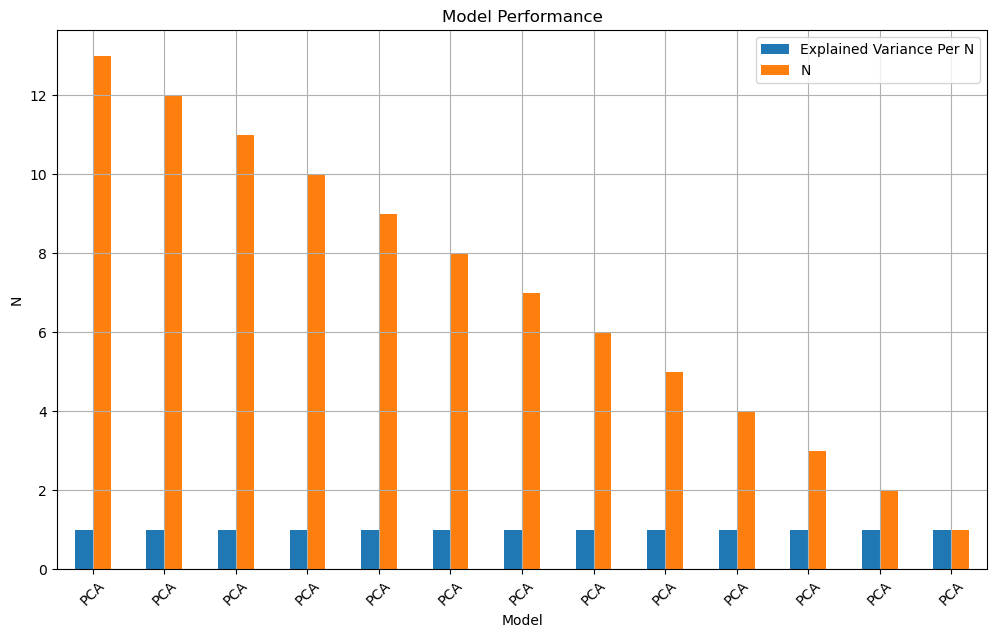

   Model  Explained Variance Per N   N
12   PCA                  1.000000  13
11   PCA                  1.000000  12
10   PCA                  1.000000  11
9    PCA                  1.000000  10
8    PCA                  1.000000   9
7    PCA                  1.000000   8
6    PCA                  1.000000   7
5    PCA                  1.000000   6
4    PCA                  1.000000   5
3    PCA                  1.000000   4
2    PCA                  1.000000   3
1    PCA                  0.999985   2
0    PCA                  0.995111   1


In [35]:
pca_analysis(X)

# Metrics to Test For

In [26]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True)
recall_metric = make_scorer(recall_score, greater_is_better=True)
precision_metric = make_scorer(precision_score, greater_is_better=True)

# Baselinse model Performance

# Acc Metric

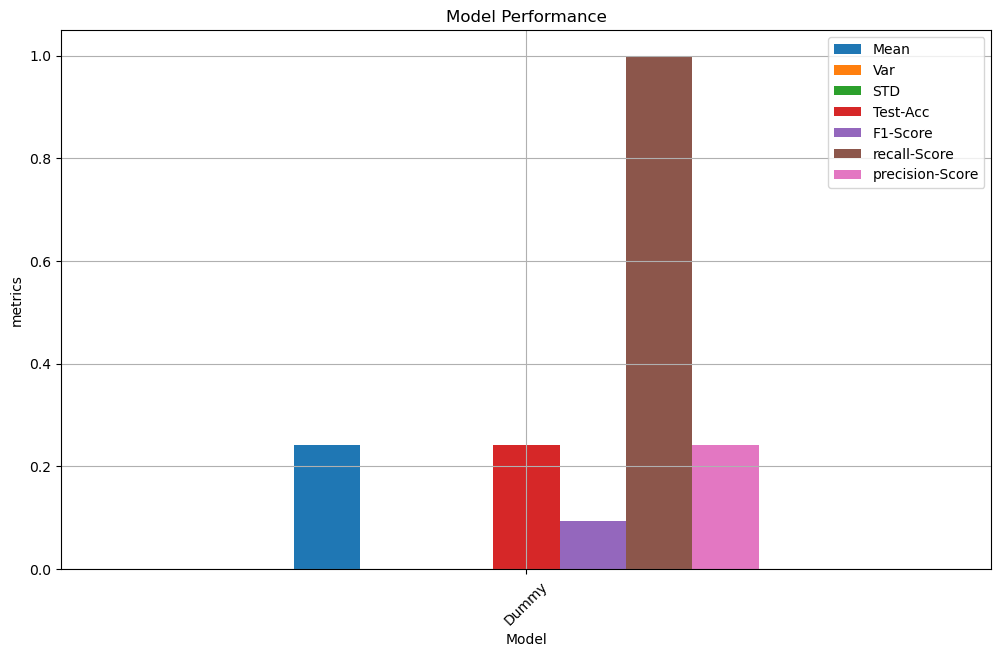

   Model   Mean  Var  STD  Test-Acc  F1-Score  recall-Score  precision-Score
0  Dummy  0.241  0.0  0.0     0.241     0.094           1.0            0.241


In [36]:
model_names = ["Dummy"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, acc_metric)

# F1 Metric

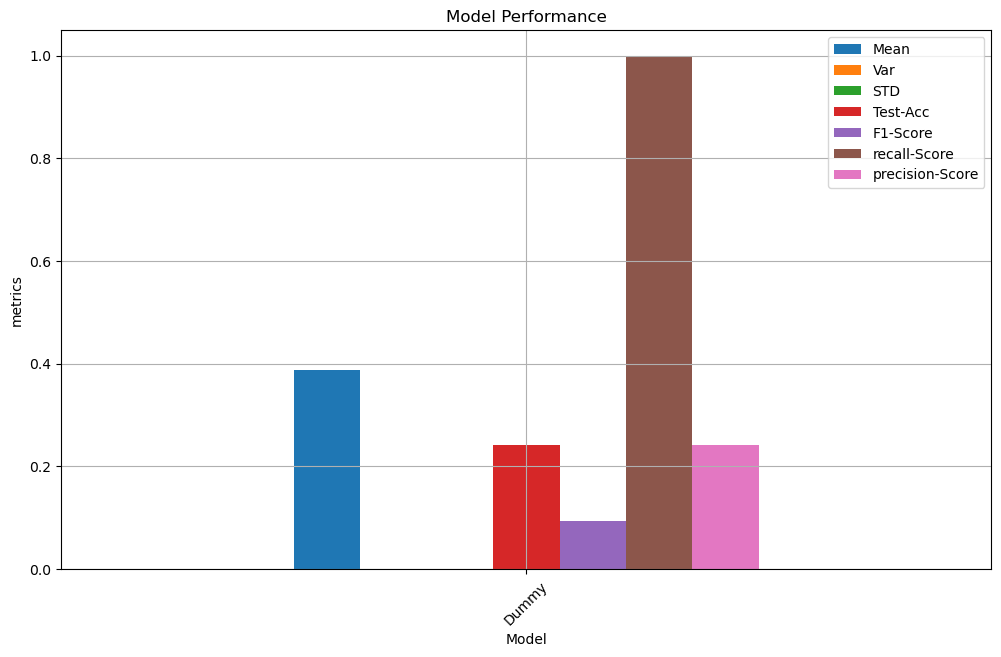

   Model   Mean  Var  STD  Test-Acc  F1-Score  recall-Score  precision-Score
0  Dummy  0.388  0.0  0.0     0.241     0.094           1.0            0.241


In [46]:
model_names = ["Dummy"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, f1_metric)

# Precision Metric

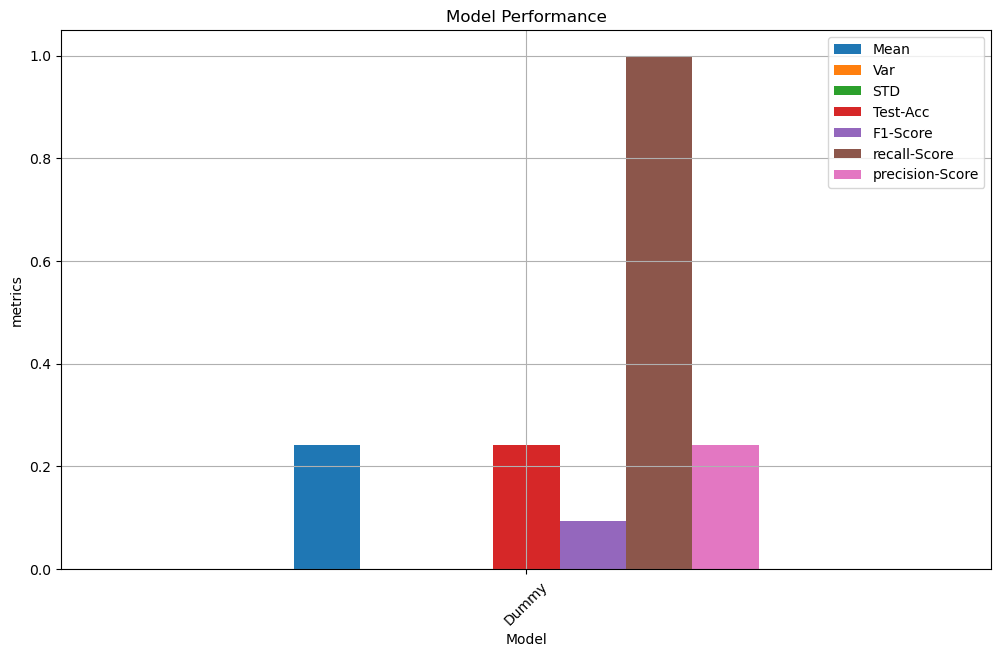

   Model   Mean  Var  STD  Test-Acc  F1-Score  recall-Score  precision-Score
0  Dummy  0.241  0.0  0.0     0.241     0.094           1.0            0.241


In [47]:
model_names = ["Dummy"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, precision_metric)

# Advanced Model Metrics

# Acc Metric

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


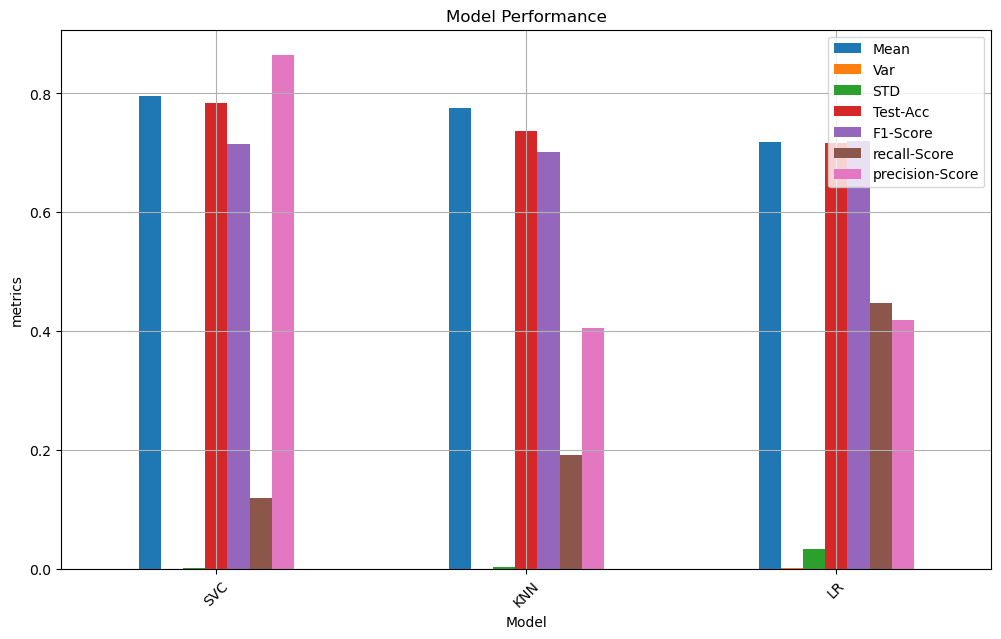

  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
1   SVC  0.795  0.000  0.002     0.783     0.714         0.119   
2   KNN  0.776  0.000  0.003     0.737     0.701         0.192   
0    LR  0.718  0.001  0.033     0.717     0.720         0.447   

   precision-Score  
1            0.864  
2            0.405  
0            0.418  


In [52]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, acc_metric)

# Acc Metric

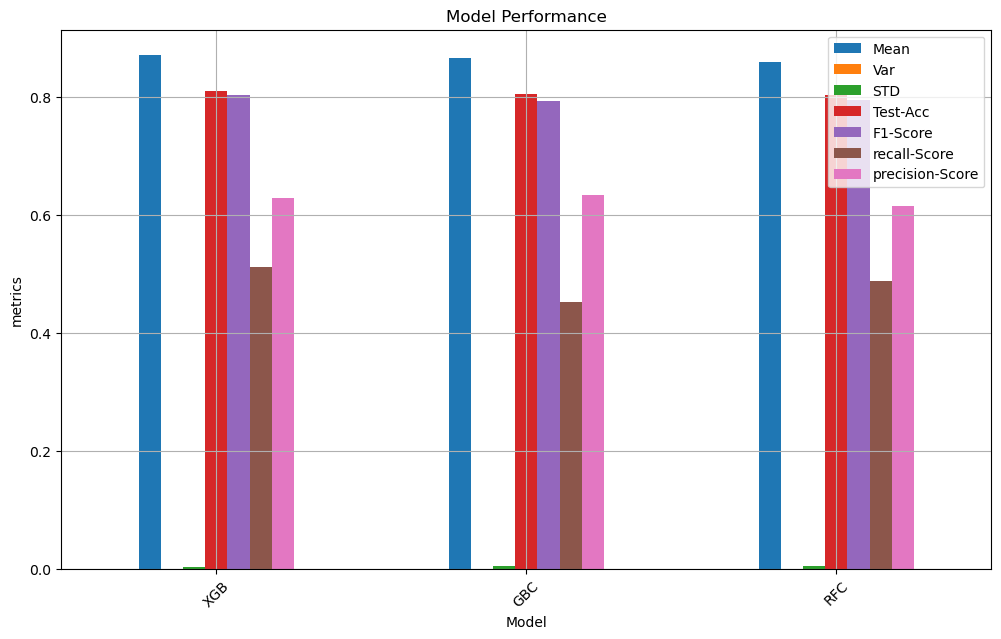

  Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  precision-Score
2   XGB  0.870  0.0  0.003     0.809     0.802         0.511            0.628
1   GBC  0.865  0.0  0.004     0.805     0.793         0.452            0.633
0   RFC  0.859  0.0  0.004     0.803     0.795         0.487            0.615


In [53]:
model_names = ["RFC", "GBC", "XGB"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, acc_metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


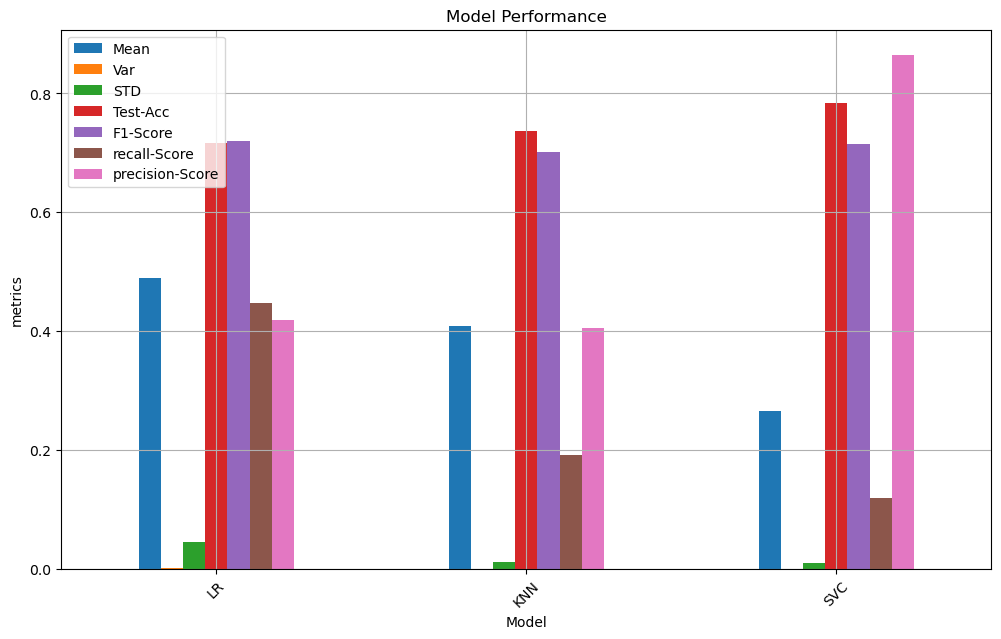

  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0    LR  0.489  0.002  0.045     0.717     0.720         0.447   
2   KNN  0.409  0.000  0.011     0.737     0.701         0.192   
1   SVC  0.265  0.000  0.010     0.783     0.714         0.119   

   precision-Score  
0            0.418  
2            0.405  
1            0.864  


In [54]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, f1_metric)

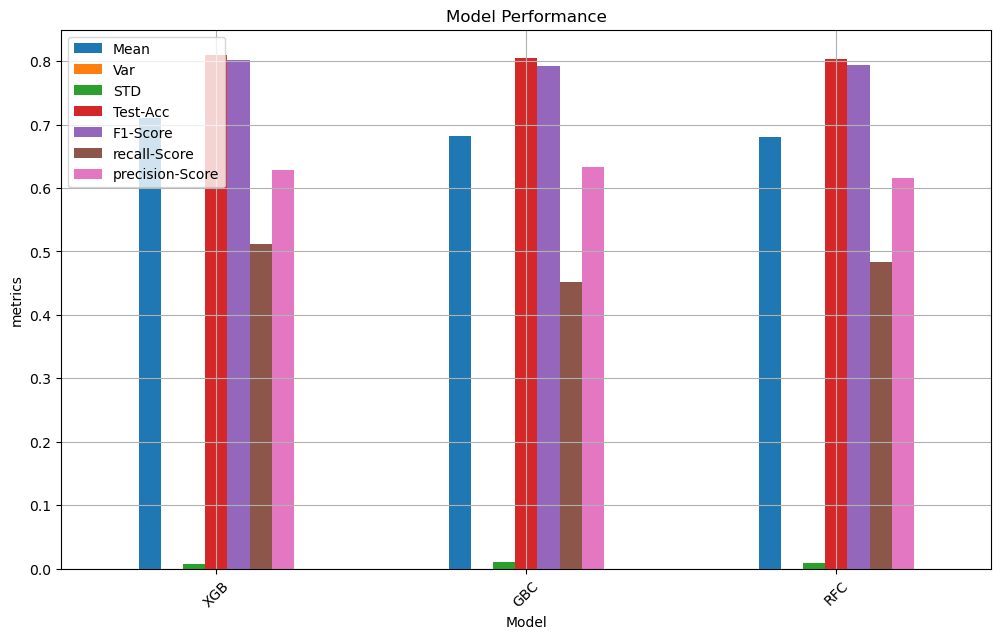

  Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  precision-Score
2   XGB  0.710  0.0  0.008     0.809     0.802         0.511            0.628
1   GBC  0.682  0.0  0.011     0.805     0.793         0.452            0.633
0   RFC  0.680  0.0  0.009     0.803     0.794         0.484            0.615


In [55]:
model_names = ["RFC", "GBC", "XGB"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, f1_metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


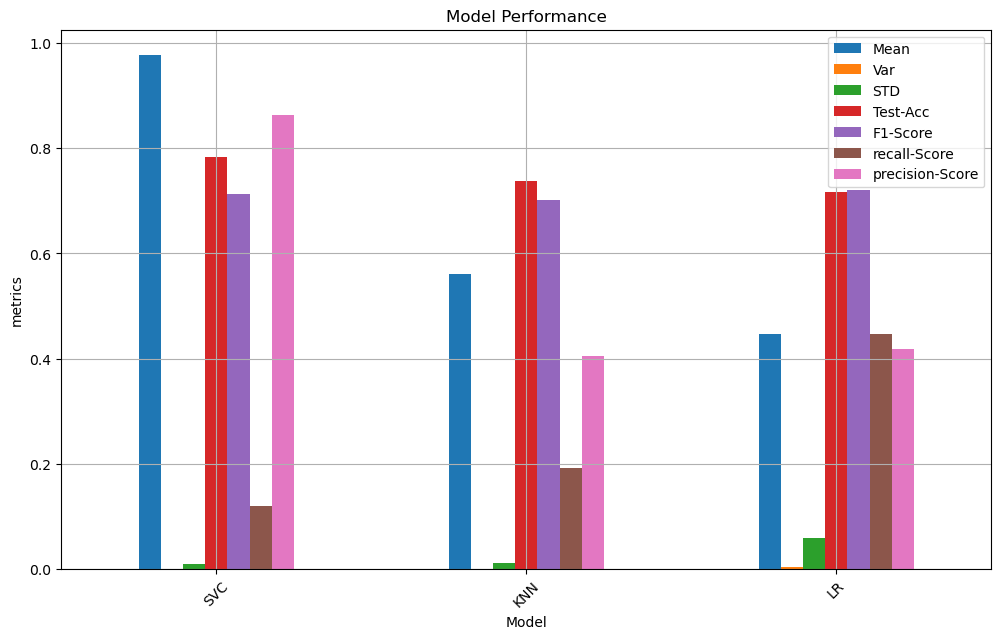

  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
1   SVC  0.977  0.000  0.009     0.783     0.714         0.119   
2   KNN  0.561  0.000  0.011     0.737     0.701         0.192   
0    LR  0.446  0.003  0.058     0.717     0.720         0.447   

   precision-Score  
1            0.864  
2            0.405  
0            0.418  


In [56]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, precision_metric)

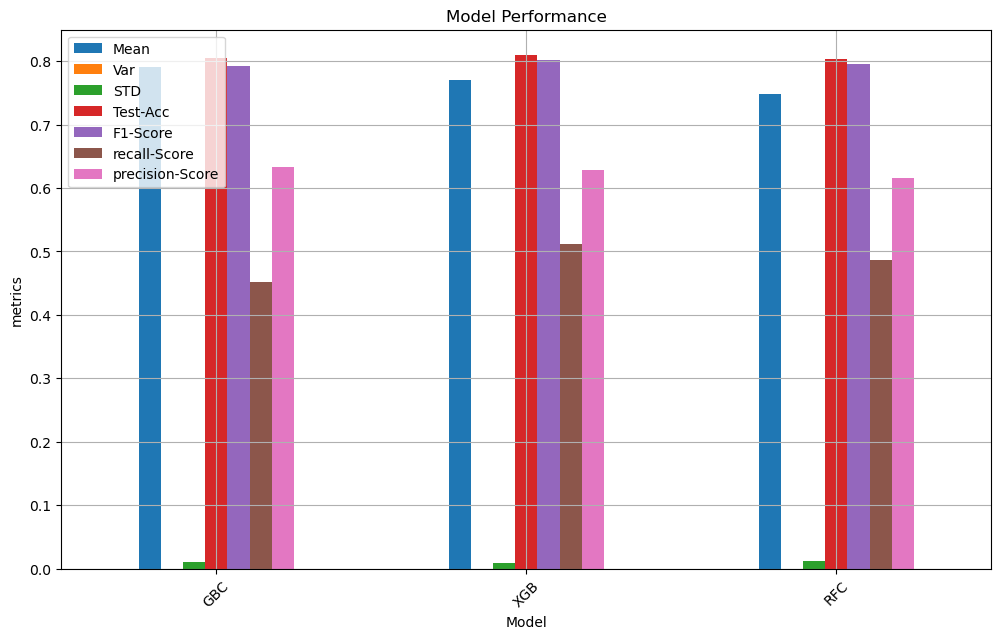

  Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  precision-Score
1   GBC  0.790  0.0  0.010     0.805     0.793         0.452            0.633
2   XGB  0.770  0.0  0.009     0.809     0.802         0.511            0.628
0   RFC  0.748  0.0  0.012     0.803     0.795         0.487            0.616


In [57]:
model_names = ["RFC", "GBC", "XGB"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y_encoded, precision_metric)

# Sampling Methods